## Imports

The function ``addCodeDirToPath`` will put the code directory onto the Python search path, regardless of where the Python Jupyter Notebook Server is excucted.

In [1]:
def addCodeDirToPath(codeDirSnippet):
    # This snippet will make sure code directory is in Python search path.  It drills up from 
    # the current working directory until the first directory in codeDirSnippet is found.  It
    # then builds a new full path that points to codeDirSnippet and appends it to Python's path.
    # It is designed such that it only runs once by only running if 'haveAddedCodeDirToPath' is
    # defined.
    global haveAddedCodeDirToPath
    try: #This is a run-once hack.  
        haveAddedCodeDirToPath
    except NameError:
        haveAddedCodeDirToPath = 'yes'
        codeDirSnippetList = codeDirSnippet.split(os.path.sep)
        codeDirList = list(filter(lambda x: x!='', codeDirSnippetList))
        targetDir = codeDirList[0]
        startPath = os.path.abspath(os.path.curdir)
        while True:
            (path, lastDir) = os.path.split(startPath)
            if lastDir != targetDir:
                startPath = path
            else:
                break
        codePath = os.path.join(path, *codeDirList)
        print('added:', codePath)
        sys.path.append(codePath)

In [2]:
import sys, os
codePath = os.path.join('Helmholtz','Helmholtz')
addCodeDirToPath(codePath)

added: C:\Users\brian\Desktop\Helmholtz\Helmholtz


In [3]:
import traceback
import numpy as np
from importlib import reload  # Python 3.4+ only.

In [4]:
import EMSim_Helmholtz
reload(EMSim_Helmholtz);

# Demos

## Wave Interference

Begin by defining a simulation.
  - `xyShape`: The simulation has an integer number of points in the x and y directions.
  - `WL0`: The number of pixels per wavelength

In [5]:
sim = EMSim_Helmholtz.EMSim(xyShape=(50, 50), WL0=10)

The geometry consists of four absorbing walls.  The inner region can be built with various structures.  The 'permittivity', known by the symbol epsilon $\epsilon$, defines the material value.  The permittivity is a generally a complex number.  Air has a permittivity of 1.0.  Glass has a permittivity of ~2.  Absorbing materials have permittivities which have a negative imaginary part.

Below we define a disk of glass and visualize it.

Our simulation needs energy sources.  These are defined in a similar point-by-point fashion.  Note that the sources are defined with a complex number.  Values of `[1., 1.j, -1., -1.j]` all have the same magnitude, but are 90deg off of each other in phase. 

In [6]:
sim.setPointSource((20, 5), 1.)
sim.setPointSource((30, 5), 1.)

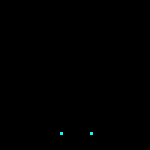

In [7]:
sim.visualizeSources()

These sources will generate waves which we will calculate in a second.  First we must define what we which they would do.  This is done by defining the complex value wave value at a series of points in space.  How well a design does will be depend on how close the fields are to the goal values at the designated points.

We then build all of the equations which define the physics and solve it.

In [8]:
sim.buildEquations()
sim.solve()

Not much appeared to happen, however internal values matrices were populated with the field solution.  If it went poorly, you might get an error message saying `"FAILED!!!"`.  We can observ the field.  Notice the wave eminating from our line of sources in the lower left corner.  Also note how our glass disk focuses the wave to a point near the upper right hand corner.

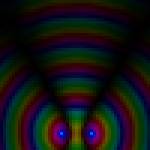

In [9]:
sim.visualizeFields()

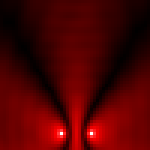

In [10]:
sim.visualizeFieldsMag()

## Ball Lens

In [11]:
sim = EMSim_Helmholtz.EMSim(xyShape=(50, 50), WL0=10)

In [12]:
for x in range(50):
    for y in range(50):
        if (x-25)**2 + (y-25)**2 < 10**2:
            sim.setEpsPoint((x,y), 2.)

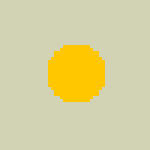

In [13]:
sim.visualizeMaterial(1., 2.)

In [14]:
for x in range(5,45):
    sim.setPointSource((x, 3), 1.)
    sim.setPointSource((x, 2), -1.)

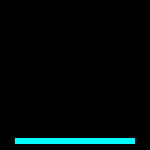

In [15]:
sim.visualizeSources()

In [16]:
sim.buildEquations()
sim.solve()

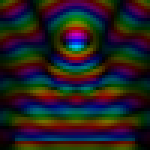

In [17]:
sim.visualizeFields()

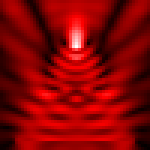

In [18]:
sim.visualizeFieldsMag()

## Waveguides

In [19]:
sim = EMSim_Helmholtz.EMSim(xyShape=(200, 50), WL0=10)

In [20]:
for x in range(11,170):
    for y in range(23,27):
        sim.setEpsPoint((x,y), 2.)

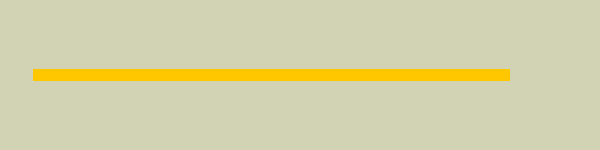

In [21]:
sim.visualizeMaterial(1., 2.)

In [22]:
sim.setPointSource((10, 25), 1.)

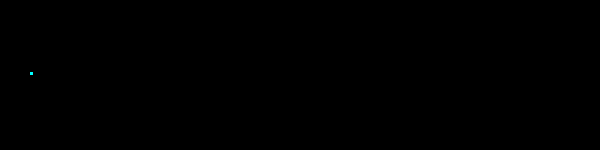

In [23]:
sim.visualizeSources()

In [24]:
sim.buildEquations()
sim.solve()

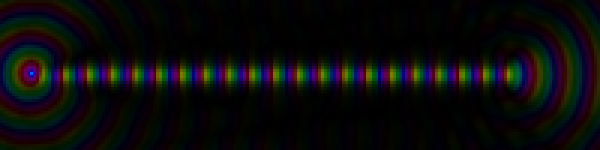

In [25]:
sim.visualizeFields()

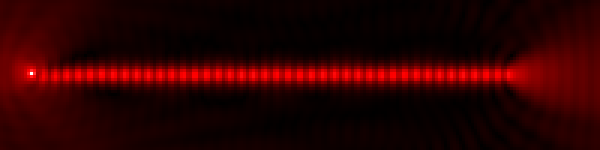

In [26]:
sim.visualizeFieldsMag()

In [27]:
sim = EMSim_Helmholtz.EMSim(xyShape=(200, 50), WL0=10)

In [28]:
for x in range(11,170):
    for y in range(23,27):
        sim.setEpsPoint((x,y), 2.)

In [29]:
sim.setPointSource((25, 10), 1.)

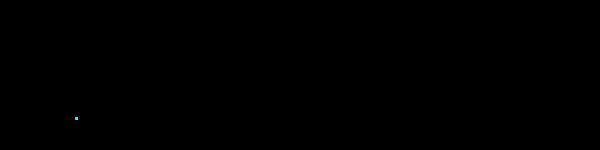

In [30]:
sim.visualizeSources()

In [31]:
sim.buildEquations()
sim.solve()

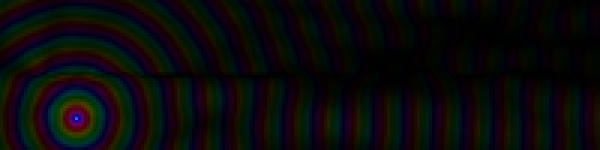

In [32]:
sim.visualizeFields()

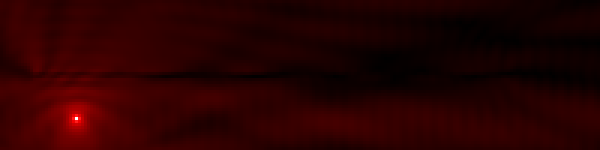

In [33]:
sim.visualizeFieldsMag()

## Phased Array

In [34]:
sim = EMSim_Helmholtz.EMSim(xyShape=(200, 200), WL0=10)

In [35]:
for x in range(20,180, 5):
    (targX, targY) = (100, 180)
    dist = np.sqrt((x-targX)**2 + (y-targY)**2)
    sim.setPointSource((x, 25), np.exp(-(0+1j)*sim.k0*dist))

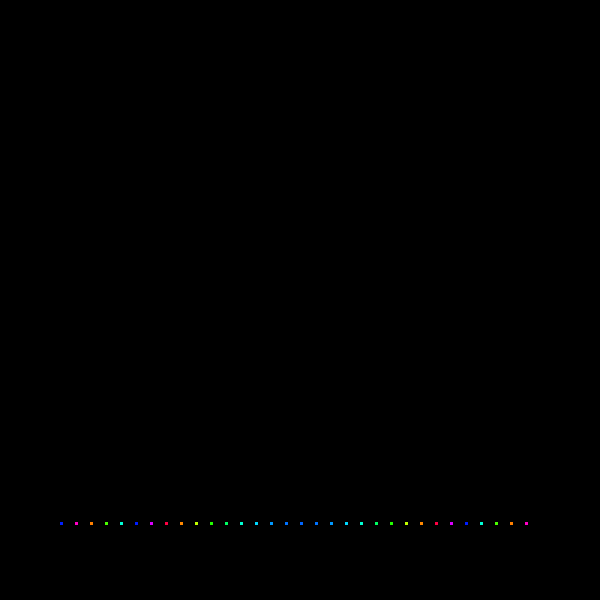

In [36]:
sim.visualizeSources()

In [37]:
sim.buildEquations()
sim.solve()

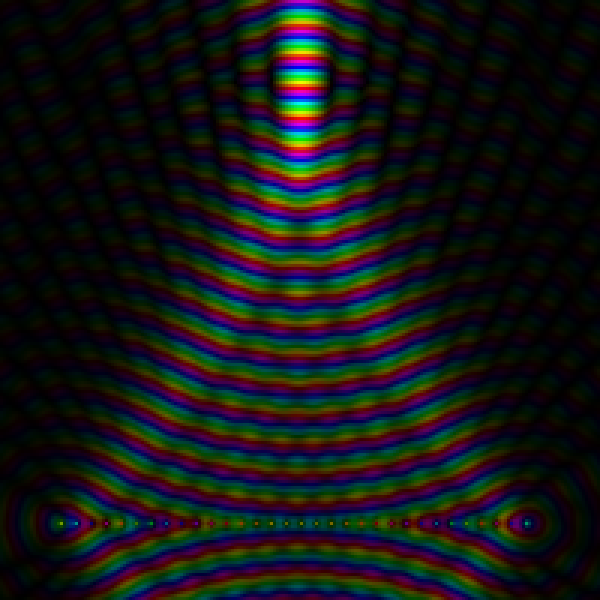

In [38]:
sim.visualizeFields()